We'll start by importing all necessary libraries.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import visualkeras
import tensorflow as tf
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm_notebook

Loading the two datasets that will be used. The '15-'16 season will be used for training, while the next season is used for testing

In [8]:
df_train1 = pd.read_csv('data/NBA_PBP_2015-16.csv')
df_train2 = pd.read_csv('data/NBA_PBP_2016-17.csv')
df_train3 = pd.read_csv('data/NBA_PBP_2017-18.csv')
df_train4 = pd.read_csv('data/NBA_PBP_2018-19.csv')
df_train5 = pd.read_csv('data/NBA_PBP_2019-20.csv')

del df_train5['Unnamed: 40']

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5])

df_test = pd.read_csv('data/NBA_PBP_2020-21.csv')

In [9]:
df_train = df_train.reset_index(drop=True)

Below, we have the selected features and a list of their names for the feature vectors that will be constructed later.

In [10]:
factors = ['Quarter','ShotType','ShotDist','FoulType',
           'TimeoutTeam','EnterGame','LeaveGame', 'Shooter',
           'Rebounder', 'Blocker','Fouler',
          'Fouled','ReboundType','ViolationPlayer', 'ViolationType',
          'FreeThrowShooter','TurnoverPlayer','TurnoverType','TurnoverCause',
           'TurnoverCauser']

fact_cols = [col + str((i // 20) % 10 + 1) for i, col in enumerate(factors * 10)]
fact_cols.append('class')


The encoders() function creates a different label encoder instance for each feature so that they can be encoded and decoded independently.

In [11]:
def encoders(data):
    for factor in factors:
        globals()[f'{factor}_le'] = LabelEncoder()
        data[factor] = globals()[f'{factor}_le'].fit_transform(data[factor])
    return df_train

encoders(df_train)

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,AwayScore,HomeTeam,HomePlay,HomeScore,Shooter,ShotType,ShotOutcome,ShotDist,Assister,Blocker,FoulType,Fouler,Fouled,Rebounder,ReboundType,ViolationPlayer,ViolationType,TimeoutTeam,FreeThrowShooter,FreeThrowOutcome,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss
0,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,0,720,DET,Jump ball: A. Drummond vs. A. Horford (E. lyas...,0,ATL,NaN,0,940,8,NaN,89,NaN,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,A. Drummond - drumman01,A. Horford - horfoal01,E. İlyasova - ilyaser01
1,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,0,701,DET,A. Drummond misses 2-pt layup from 1 ft (block...,0,ATL,NaN,0,18,3,miss,1,NaN,27,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
2,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,0,699,DET,NaN,0,ATL,Defensive rebound by K. Bazemore,0,940,8,NaN,89,NaN,831,14,970,909,503,0,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
3,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,0,697,DET,NaN,0,ATL,Turnover by K. Bazemore (bad pass),0,940,8,NaN,89,NaN,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,492,5,1,885,NaN,NaN,NaN
4,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,0,681,DET,M. Morris makes 2-pt jump shot from 13 ft (ass...,2,ATL,NaN,0,643,2,make,13,A. Drummond - drumman01,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942846,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,3,29,LAL,NaN,103,MIA,K. Olynyk makes 2-pt layup from 2 ft,90,544,3,make,2,NaN,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
2942847,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,3,20,LAL,D. Howard makes 3-pt jump shot from 30 ft (ass...,106,MIA,NaN,90,208,6,make,30,A. Caruso - carusal01,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
2942848,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,3,15,LAL,NaN,106,MIA,S. Hill makes 3-pt jump shot from 29 ft,93,794,6,make,29,NaN,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN
2942849,/boxscores/202010110MIA.html,playoff,The Arena Bay Lake Florida,October 11 2020,7:30 PM,LAL,3,0,LAL,End of 4th quarter,106,MIA,NaN,93,940,8,NaN,89,NaN,831,14,970,909,930,2,525,7,30,892,NaN,NaN,943,900,901,29,1,885,NaN,NaN,NaN


The next two functions iterate over the whole dataframe and creates lists of the moments a basket that contributes to a run occurs.


In [12]:
def home_runner(data):
    global home_runs
    run = []
    home_runs = []
    for idx in data.index:
        if data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.append(idx)
        elif data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.clear()
        if len(run) == 4:
            home_runs.append(run.copy())
            run.clear()
    return home_runs
                

home_runner(df_train)



def away_runner(data):
    global away_runs
    run = []
    away_runs = []
    for idx in data.index:
        if data.at[idx,'AwayPlay'] is not np.nan:
                if 'makes' in data.at[idx,'AwayPlay']:
                    run.append(idx)
        elif data.at[idx,'HomePlay'] is not np.nan:
                if 'makes' in data.at[idx,'HomePlay']:
                    run.clear()
        if len(run) == 4:
            away_runs.append(run.copy())
            run.clear()
    return away_runs

away_runner(df_train)

all_runs = []
all_runs.extend(home_runs)
all_runs.extend(away_runs)


The runs_iter() function looks for 10 events before the start of the run. It then picks specific columns of interest. The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label that indicates this is a run.

In [13]:
#The data from those columns get flattened in an 1d array, which is then added to a new dataframe, along with a label
#that indicates this is a run.

def runs_iter(data):
    global runs_df
    runs_df = pd.DataFrame()
    for run in all_runs:
        a = data.loc[run[0]-10:run[0]-1, factors].values.ravel()
        a = np.append(a,1)
        runs_df = pd.concat([runs_df,pd.DataFrame([a.copy()])])
    return runs_df

runs_iter(df_train)
runs_df.columns = fact_cols
runs_df

,Quarter1,ShotType1,ShotDist1,FoulType1,TimeoutTeam1,EnterGame1,LeaveGame1,Shooter1,Rebounder1,Blocker1,Fouler1,Fouled1,ReboundType1,ViolationPlayer1,ViolationType1,FreeThrowShooter1,TurnoverPlayer1,TurnoverType1,TurnoverCause1,TurnoverCauser1,Quarter2,ShotType2,ShotDist2,FoulType2,TimeoutTeam2,EnterGame2,LeaveGame2,Shooter2,Rebounder2,Blocker2,Fouler2,Fouled2,ReboundType2,ViolationPlayer2,ViolationType2,FreeThrowShooter2,TurnoverPlayer2,TurnoverType2,TurnoverCause2,TurnoverCauser2,Quarter3,ShotType3,ShotDist3,FoulType3,TimeoutTeam3,EnterGame3,LeaveGame3,Shooter3,Rebounder3,Blocker3,Fouler3,Fouled3,ReboundType3,ViolationPlayer3,ViolationType3,FreeThrowShooter3,TurnoverPlayer3,TurnoverType3,TurnoverCause3,TurnoverCauser3,Quarter4,ShotType4,ShotDist4,FoulType4,TimeoutTeam4,EnterGame4,LeaveGame4,Shooter4,Rebounder4,Blocker4,Fouler4,Fouled4,ReboundType4,ViolationPlayer4,ViolationType4,FreeThrowShooter4,TurnoverPlayer4,TurnoverType4,TurnoverCause4,TurnoverCauser4,Quarter5,ShotType5,ShotDist5,FoulType5,TimeoutTeam5,EnterGame5,LeaveGame5,Shooter5,Rebounder5,Blocker5,Fouler5,Fouled5,ReboundType5,ViolationPlayer5,ViolationType5,FreeThrowShooter5,TurnoverPlayer5,TurnoverType5,TurnoverCause5,TurnoverCauser5,Quarter6,ShotType6,ShotDist6,FoulType6,TimeoutTeam6,EnterGame6,LeaveGame6,Shooter6,Rebounder6,Blocker6,Fouler6,Fouled6,ReboundType6,ViolationPlayer6,ViolationType6,FreeThrowShooter6,TurnoverPlayer6,TurnoverType6,TurnoverCause6,TurnoverCauser6,Quarter7,ShotType7,ShotDist7,FoulType7,TimeoutTeam7,EnterGame7,LeaveGame7,Shooter7,Rebounder7,Blocker7,Fouler7,Fouled7,ReboundType7,ViolationPlayer7,ViolationType7,FreeThrowShooter7,TurnoverPlayer7,TurnoverType7,TurnoverCause7,TurnoverCauser7,Quarter8,ShotType8,ShotDist8,FoulType8,TimeoutTeam8,EnterGame8,LeaveGame8,Shooter8,Rebounder8,Blocker8,Fouler8,Fouled8,ReboundType8,ViolationPlayer8,ViolationType8,FreeThrowShooter8,TurnoverPlayer8,TurnoverType8,TurnoverCause8,TurnoverCauser8,Quarter9,ShotType9,ShotDist9,FoulType9,TimeoutTeam9,EnterGame9,LeaveGame9,Shooter9,Rebounder9,Blocker9,Fouler9,Fouled9,ReboundType9,ViolationPlayer9,ViolationType9,FreeThrowShooter9,TurnoverPlayer9,TurnoverType9,TurnoverCause9,TurnoverCauser9,Quarter10,ShotType10,ShotDist10,FoulType10,TimeoutTeam10,EnterGame10,LeaveGame10,Shooter10,Rebounder10,Blocker10,Fouler10,Fouled10,ReboundType10,ViolationPlayer10,ViolationType10,FreeThrowShooter10,TurnoverPlayer10,TurnoverType10,TurnoverCause10,TurnoverCauser10,class
0,0,8,89,11,30,943,900,940,930,831,251,736,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,721,901,29,1,885,0,3,1,14,30,943,900,242,930,831,970,909,2,525,7,892,901,29,1,885,0,2,20,14,30,943,900,797,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,871,831,970,909,0,525,7,892,901,29,1,885,0,2,19,14,30,943,900,881,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,18,831,970,909,0,525,7,892,901,29,1,885,0,3,0,14,30,943,900,18,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,892,236,5,0,486,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,892,496,16,0,830,1
0,3,8,89,14,30,943,900,940,284,831,970,909,1,525,7,892,901,29,1,885,3,3,0,14,30,943,900,286,930,831,970,909,2,525,7,892,901,29,1,885,3,8,89,14,30,943,900,940,18,831,970,909,1,525,7,892,901,29,1,885,3,3,0,14,30,943,900,286,930,831,970,909,2,525,7,892,901,29,1,885,3,8,89,11,30,943,900,940,930,831,19,470,2,525,7,892,901,29,1,885,3,8,89,14,30,943,900,940,930,831,970,909,2,525,7,460,901,29,1,885,3,8,89,14,30,943,900,940,887,831,970,909,1,525,7,892,901,29,1,885,3,8,89,14,30,800,276,940,930,831,970,909,2,525,7,892,901,29,1,885,3,8,89,14,30,582,236,940,930,831,970,909,2,525,7,892,901,29,1,885,3,8,89,14,30,27,632,940,930,831,970,909,2,525,7,892,901,29,1,885,1
0,0,3,2,14,30,943,900,365,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,565,831,970,909,0,525,7,892,901,29,1,885,0,6,25,14,30,943,900,671,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,4

The precipitating events for the runs are removed from the dataframe and a similar function assigns labels of 0 to no_runs.

In [14]:
def no_runs_preprocessing(data):
    global no_runs_split
    
    # find the first index of a run
    r = [i[0] for i in all_runs]  

    # create a list of runs
    r_x = []
    for num in r:
        r_x.extend(range(num - 10, num + 1))

    # mask the df without runs
    no_runs_df = data[~data.index.isin(r_x)].reset_index(drop=True)

    # segment the df and keep those that are length of 10
    segment_size = 10
    segments = len(no_runs_df) // segment_size

    no_runs_split = np.array_split(no_runs_df, segments)

    no_runs_split = [x for x in no_runs_split if len(x) != 11]

    return no_runs_split

In [15]:
def no_runs_optimized(data, factors, fact_cols):
    global no_runs_df
    no_runs_df = pd.DataFrame([np.append(segment.loc[:, factors].values.ravel(), int(0)) for segment in data])
    no_runs_df.columns = fact_cols
    return no_runs_df

no_runs_optimized(no_runs_preprocessing(df_train), factors, fact_cols)

,Quarter1,ShotType1,ShotDist1,FoulType1,TimeoutTeam1,EnterGame1,LeaveGame1,Shooter1,Rebounder1,Blocker1,Fouler1,Fouled1,ReboundType1,ViolationPlayer1,ViolationType1,FreeThrowShooter1,TurnoverPlayer1,TurnoverType1,TurnoverCause1,TurnoverCauser1,Quarter2,ShotType2,ShotDist2,FoulType2,TimeoutTeam2,EnterGame2,LeaveGame2,Shooter2,Rebounder2,Blocker2,Fouler2,Fouled2,ReboundType2,ViolationPlayer2,ViolationType2,FreeThrowShooter2,TurnoverPlayer2,TurnoverType2,TurnoverCause2,TurnoverCauser2,Quarter3,ShotType3,ShotDist3,FoulType3,TimeoutTeam3,EnterGame3,LeaveGame3,Shooter3,Rebounder3,Blocker3,Fouler3,Fouled3,ReboundType3,ViolationPlayer3,ViolationType3,FreeThrowShooter3,TurnoverPlayer3,TurnoverType3,TurnoverCause3,TurnoverCauser3,Quarter4,ShotType4,ShotDist4,FoulType4,TimeoutTeam4,EnterGame4,LeaveGame4,Shooter4,Rebounder4,Blocker4,Fouler4,Fouled4,ReboundType4,ViolationPlayer4,ViolationType4,FreeThrowShooter4,TurnoverPlayer4,TurnoverType4,TurnoverCause4,TurnoverCauser4,Quarter5,ShotType5,ShotDist5,FoulType5,TimeoutTeam5,EnterGame5,LeaveGame5,Shooter5,Rebounder5,Blocker5,Fouler5,Fouled5,ReboundType5,ViolationPlayer5,ViolationType5,FreeThrowShooter5,TurnoverPlayer5,TurnoverType5,TurnoverCause5,TurnoverCauser5,Quarter6,ShotType6,ShotDist6,FoulType6,TimeoutTeam6,EnterGame6,LeaveGame6,Shooter6,Rebounder6,Blocker6,Fouler6,Fouled6,ReboundType6,ViolationPlayer6,ViolationType6,FreeThrowShooter6,TurnoverPlayer6,TurnoverType6,TurnoverCause6,TurnoverCauser6,Quarter7,ShotType7,ShotDist7,FoulType7,TimeoutTeam7,EnterGame7,LeaveGame7,Shooter7,Rebounder7,Blocker7,Fouler7,Fouled7,ReboundType7,ViolationPlayer7,ViolationType7,FreeThrowShooter7,TurnoverPlayer7,TurnoverType7,TurnoverCause7,TurnoverCauser7,Quarter8,ShotType8,ShotDist8,FoulType8,TimeoutTeam8,EnterGame8,LeaveGame8,Shooter8,Rebounder8,Blocker8,Fouler8,Fouled8,ReboundType8,ViolationPlayer8,ViolationType8,FreeThrowShooter8,TurnoverPlayer8,TurnoverType8,TurnoverCause8,TurnoverCauser8,Quarter9,ShotType9,ShotDist9,FoulType9,TimeoutTeam9,EnterGame9,LeaveGame9,Shooter9,Rebounder9,Blocker9,Fouler9,Fouled9,ReboundType9,ViolationPlayer9,ViolationType9,FreeThrowShooter9,TurnoverPlayer9,TurnoverType9,TurnoverCause9,TurnoverCauser9,Quarter10,ShotType10,ShotDist10,FoulType10,TimeoutTeam10,EnterGame10,LeaveGame10,Shooter10,Rebounder10,Blocker10,Fouler10,Fouled10,ReboundType10,ViolationPlayer10,ViolationType10,FreeThrowShooter10,TurnoverPlayer10,TurnoverType10,TurnoverCause10,TurnoverCauser10,class
0,0,8,89,14,30,5,18,940,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,786,730,940,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,27,695,940,930,831,970,909,2,525,7,892,901,29,1,885,0,3,1,14,30,943,900,242,930,831,970,909,2,525,7,892,901,29,1,885,0,2,21,14,30,943,900,643,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,887,831,970,909,0,525,7,892,901,29,1,885,0,3,0,14,30,943,900,242,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,892,768,5,0,830,0,6,22,14,30,943,900,580,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,892,5,16,0,830,0
1,0,3,1,14,30,943,900,242,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,887,831,970,909,0,525,7,892,901,29,1,885,0,8,89,5,30,943,900,940,930,831,915,6,2,525,7,892,901,29,1,885,0,8,89,14,30,446,495,940,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,649,849,940,930,831,970,909,2,525,7,892,901,29,1,885,0,6,35,14,30,943,900,783,930,831,970,909,2,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,887,831,970,909,1,525,7,892,901,29,1,885,0,8,89,14,30,943,900,940,930,831,970,909,2,525,7,892,901,29,1,885,1,8,89,14,30,943,900,940,930,831,970,909,2,503,1,892,901,29,1,885,1,2,14,14,30,943,900,646,930,831,970,909,2,525,7,892,901,29,1,885,0
2,1,8,89,14,30,943,900,940,284,831,970,909,0,525,7,892,901,29,1,885,1,2,14,14,30,943,900,797,930,831,970,909,2,525,7,892,901,29,1,885,1,8,89,14,30,943,900,940,522,831,970,909,0,525,7,892,901,29,1,885,1,3,1,14,30,943,900,242,930,

In [16]:
# Original function. Deprecated. 

# def no_runs_iter(data):
#     global no_runs_df
#     no_runs_df = pd.DataFrame()
#     for run in all_runs[:1]:
#         data.drop(data.index[run[0]-10:run[0]-1],inplace=True)

#     for idx in range(0, len(data), 10):
#         b = data.loc[idx:idx+9, factors].values.ravel()
#         b = np.append(b,int(0))
#         no_runs_df = pd.concat([no_runs_df,pd.DataFrame([b.copy()])])

        
#     return no_runs_df
    

# no_runs_iter(df_train)
# no_runs_df.columns = fact_cols
# no_runs_df


To avoid label imbalance, we'll undersample the no_runs dataframe.

In [17]:
no_runs_df=no_runs_df.sample(frac=0.14)

We'll combine the two frames into a final one.

In [18]:
combined_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
final_df = combined_df.dropna().astype(int)

And then scale the values.

In [19]:
scaler = MinMaxScaler((0,255))
final_df.iloc[:,:-1] = scaler.fit_transform(final_df.iloc[:,:-1])

Splitting the dataframe into training and testing sets.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:, :-1],final_df.iloc[:, -1], 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

The instances of each label look fairly balanced.

In [21]:
y_test.value_counts()

class
0    10748
1    10490
Name: count, dtype: int64

Re-shaping the arrays for keras and normalizing.

In [22]:
num_categories = 2
y_train = keras.utils.to_categorical(y_train.values, num_categories)
y_test = keras.utils.to_categorical(y_test.values, num_categories)

In [23]:
a = X_train.values.reshape(-1,20,10)
b = X_test.values.reshape(-1,20,10)

In [24]:
a = a / 255
b = b / 255

Example of each array.

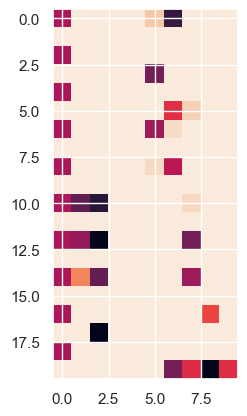

In [25]:
plt.imshow(a[30])
plt.show()

Below we have the structure of the convolutional network.

In [42]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(50, (5, 5), strides=1, padding="same", activation="relu", 
                 input_shape=(20,10,1)))   
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25,(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=num_categories, activation="softmax"))
model.compile(loss="binary_crossentropy", metrics=["accuracy"],optimizer='rmsprop')

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 10, 50)        1300      
                                                                 
 batch_normalization_2 (Bat  (None, 20, 10, 50)        200       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 5, 50)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 5, 25)         11275     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 3, 25)          0         
 g2D)                                                            
                                                      

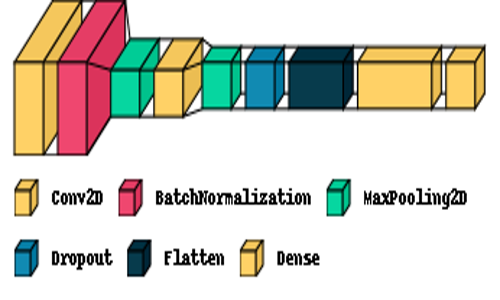

In [44]:
visualkeras.layered_view(model,legend=True, to_file='big.png').resize((500,300))

Fitting the model.

In [45]:
history = model.fit(
    a, y_train, epochs=20, verbose=1, validation_data=(b, y_test))

sum(history.history['val_accuracy'])/len(history.history['val_accuracy'])

Epoch 1/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6669 - accuracy: 0.5909 - val_loss: 0.6590 - val_accuracy: 0.6035
Epoch 2/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6489 - accuracy: 0.6113 - val_loss: 0.6408 - val_accuracy: 0.6208
Epoch 3/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6438 - accuracy: 0.6166 - val_loss: 0.6370 - val_accuracy: 0.6208
Epoch 4/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6413 - accuracy: 0.6169 - val_loss: 0.6369 - val_accuracy: 0.6259
Epoch 5/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6397 - accuracy: 0.6195 - val_loss: 0.6372 - val_accuracy: 0.6280
Epoch 6/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6371 - accuracy: 0.6237 - val_loss: 0.6299 - val_accuracy: 0.6291
Epoch 7/20
1549/1549 [==============================] - 19s 12ms/step - loss: 0.6363 - accuracy: 0.6251 - val_loss: 0.6320 -

0.626977589726448

The mean accuracy resulting from 20 epochs of training seems satisfactory. At this point we could combine the train and test sets and refit the model, so as to have more data. However, we'll avoid that for computational efficiency, given that the data is of acceptable size.

In the following lines, we're evaluating four conventional classifiers using 10-fold cross-validation.

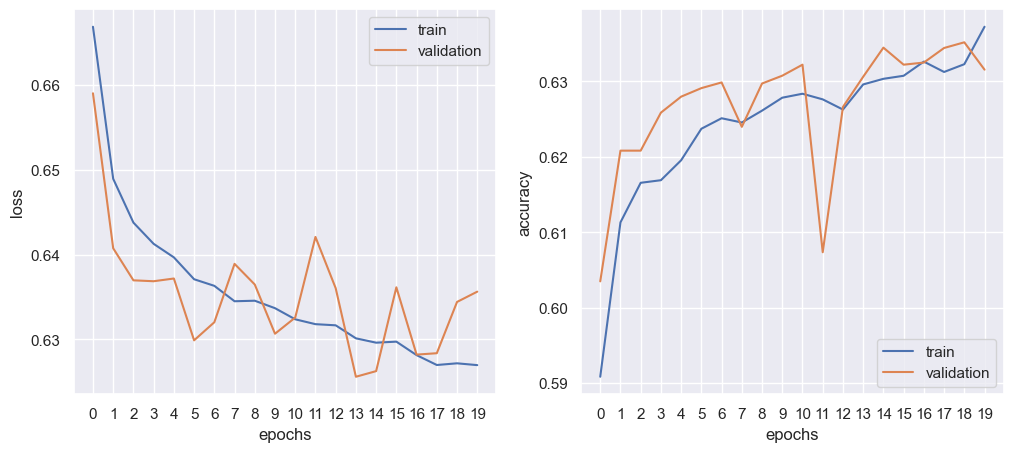

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [47]:
model.save('pretrained_model.h5')

In [95]:
classifier = [SVC(),DecisionTreeClassifier(),KNeighborsClassifier(),RandomForestClassifier()]
scoring =['accuracy','recall','precision','f1']

In [ ]:
svc = pd.DataFrame(cross_validate(classifier[0],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
svc.test_accuracy.mean()

In [123]:
dtc = pd.DataFrame(cross_validate(classifier[1],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
dtc.test_accuracy.mean()

0.5627901136664023

In [63]:
knn = pd.DataFrame(cross_validate(classifier[2],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
knn.test_accuracy.mean()

0.5363409614440543

In [45]:
rf = pd.DataFrame(cross_validate(classifier[3],final_df.iloc[:, :-1],final_df.iloc[:, -1],cv=10,scoring=scoring))
rf.test_accuracy.mean()

0.6132166458970583

Finally, we'll pre-process the '20-'21 season data in the same manner and use our model to make predictions.

In [122]:
encoders(df_test)
all_runs.clear()
home_runner(df_test)
away_runner(df_test)
all_runs.extend(home_runs)
all_runs.extend(away_runs)
runs_iter(df_test)
runs_df.columns = fact_cols
no_runs_optimized(no_runs_preprocessing(df_test),factors,fact_cols)
no_runs_df.columns = fact_cols
no_runs_df=no_runs_df.sample(frac=0.17)
combined_test_df = pd.concat([runs_df,no_runs_df],ignore_index=True)
final_test_df = combined_test_df.dropna().astype(int)
final_test_df.iloc[:,:-1] = scaler.fit_transform(final_test_df.iloc[:,:-1])
data = final_test_df.iloc[:, :-1].values.reshape(-1,20,10)
data = data / 255
labels = final_test_df.iloc[:, -1]


In [123]:
preds = model.predict(data)
y_pred = np.argmax(preds, axis = 1)
print(classification_report(labels, y_pred))

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1444
           1       0.61      0.51      0.55      1150

    accuracy                           0.64      2594
   macro avg       0.63      0.62      0.62      2594
weighted avg       0.63      0.64      0.63      2594



Our second goal is to identify the frequency of specific values in our features.

In [138]:
dec_df = combined_test_df.dropna().astype(int)

for factor in factors:
    for i in range(1,11):
        dec_df[factor+str(i)] = globals()[f'{factor}_le'].inverse_transform(dec_df[factor+str(i)])

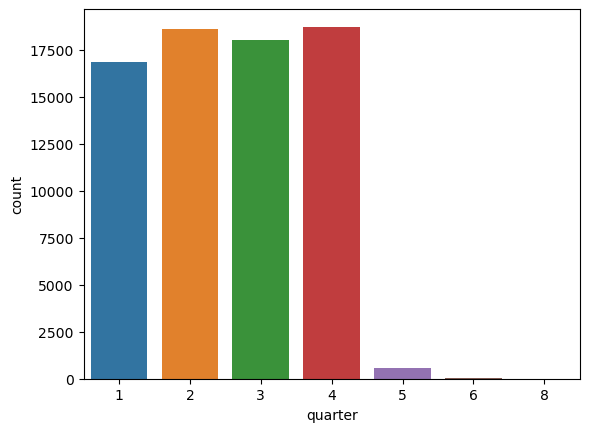

In [198]:
quarter = dec_df[dec_df['class'] == 1][['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 
                     'Quarter5', 'Quarter6', 'Quarter7', 'Quarter8', 
                     'Quarter9', 'Quarter10']]

quarter_df = pd.DataFrame(quarter.stack().reset_index())
del quarter_df['level_0']
del quarter_df['level_1']
quarter_df.columns = ['quarter']
quarter_vc = pd.DataFrame(quarter_df.value_counts())
quarter_vc.columns = ['count']
quarter_vc = quarter_vc.reset_index()
sns.barplot(data=quarter_vc, x='quarter', y='count')
plt.show()

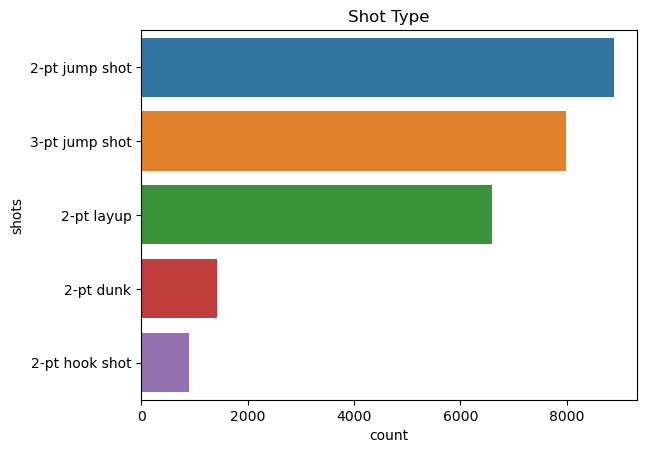

In [199]:
shots = dec_df[dec_df['class'] == 1][['ShotType1', 'ShotType2', 'ShotType3', 
                   'ShotType4', 'ShotType5', 'ShotType6', 
                   'ShotType7', 'ShotType8', 'ShotType9', 'ShotType10']]

shots_df = pd.DataFrame(shots.stack().reset_index())
del shots_df['level_0']
del shots_df['level_1']
shots_df.columns = ['shots']
shots_vc = pd.DataFrame(shots_df.value_counts())
shots_vc.columns = ['count']
sns.barplot(data = shots_vc.reset_index(), x = 'count', y = 'shots')
plt.title('Shot Type')
plt.show()

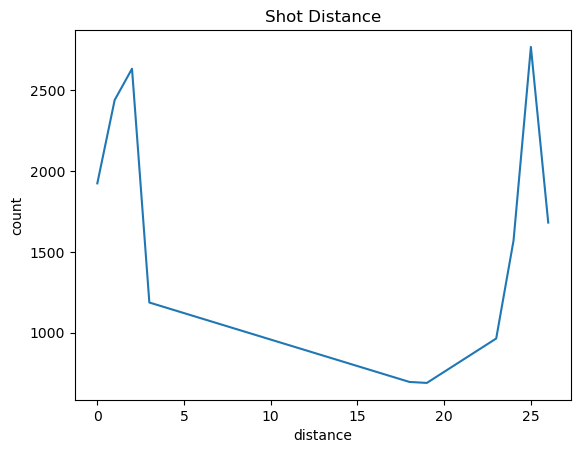

In [200]:
distance = dec_df[dec_df['class'] == 1][['ShotDist1', 'ShotDist2', 'ShotDist3', 'ShotDist4', 
                  'ShotDist5', 'ShotDist6', 'ShotDist7', 'ShotDist8', 
                  'ShotDist9', 'ShotDist10']]

distance_df = pd.DataFrame(distance.stack().reset_index())
del distance_df['level_0']
del distance_df['level_1']
distance_df.columns = ['distance']
distance_vc = pd.DataFrame(distance_df.value_counts())
distance_vc.columns = ['count']
sns.lineplot(data=distance_vc.reset_index().head(10), x = 'distance', y = 'count')
plt.title('Shot Distance')
plt.show()

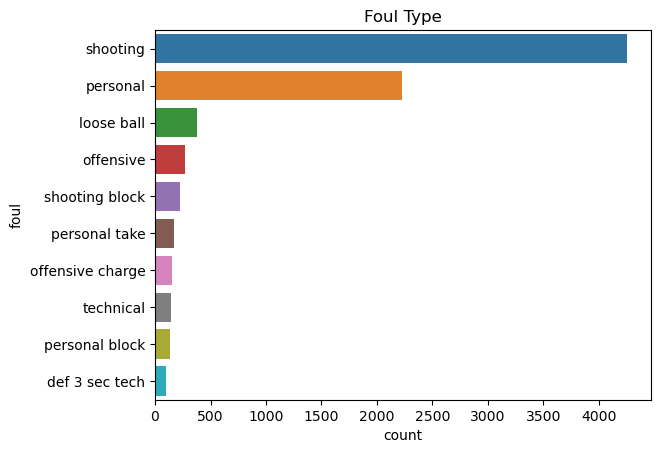

In [201]:
foul = dec_df[dec_df['class'] == 1][['FoulType1', 'FoulType2', 'FoulType3', 'FoulType4', 
                     'FoulType5', 'FoulType6', 'FoulType7', 'FoulType8', 
                     'FoulType9', 'FoulType10']]

foul_df = pd.DataFrame(foul.stack().reset_index())
del foul_df['level_0']
del foul_df['level_1']
foul_df.columns = ['foul']
foul_vc = pd.DataFrame(foul_df.value_counts())
foul_vc.columns = ['count']
sns.barplot(data=foul_vc.reset_index().head(10), x = 'count', y = 'foul')
plt.title('Foul Type')
plt.show()

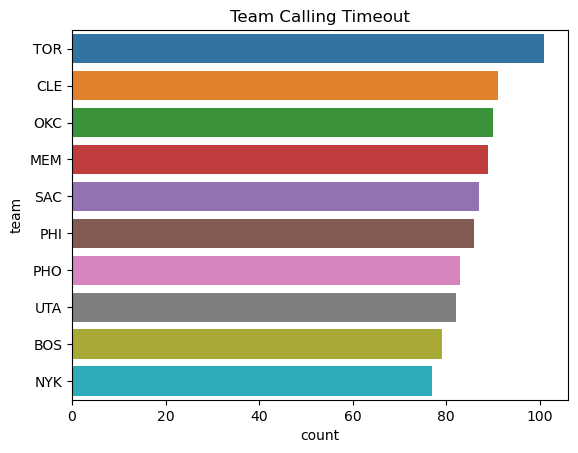

In [202]:
timeout = dec_df[dec_df['class'] == 1][['TimeoutTeam1', 'TimeoutTeam2', 'TimeoutTeam3', 'TimeoutTeam4', 
                        'TimeoutTeam5', 'TimeoutTeam6', 'TimeoutTeam7', 'TimeoutTeam8',
                        'TimeoutTeam9', 'TimeoutTeam10']]

timeout_df = pd.DataFrame(timeout.stack().reset_index())
del timeout_df['level_0']
del timeout_df['level_1']
timeout_df.columns = ['team']
timeout_vc = pd.DataFrame(timeout_df.value_counts())
timeout_vc.columns = ['count']
sns.barplot(data=timeout_vc.reset_index().head(10), x = 'count', y = 'team')
plt.title('Team Calling Timeout')
plt.show()

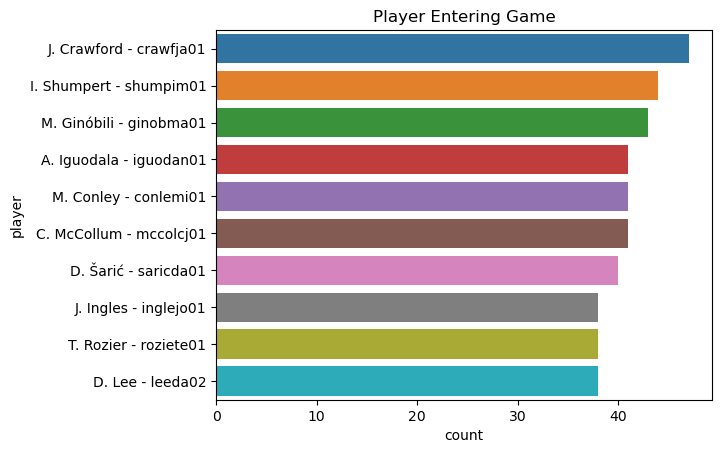

In [203]:
enter_game = dec_df[dec_df['class'] == 1][['EnterGame1', 'EnterGame2', 'EnterGame3', 'EnterGame4', 
                        'EnterGame5', 'EnterGame6', 'EnterGame7', 'EnterGame8', 
                        'EnterGame9', 'EnterGame10']]

enter_game_df = pd.DataFrame(enter_game.stack().reset_index())
del enter_game_df['level_0']
del enter_game_df['level_1']
enter_game_df.columns = ['player']
enter_game_vc = pd.DataFrame(enter_game_df.value_counts())
enter_game_vc.columns = ['count']
sns.barplot(data=enter_game_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Player Entering Game')
plt.show()

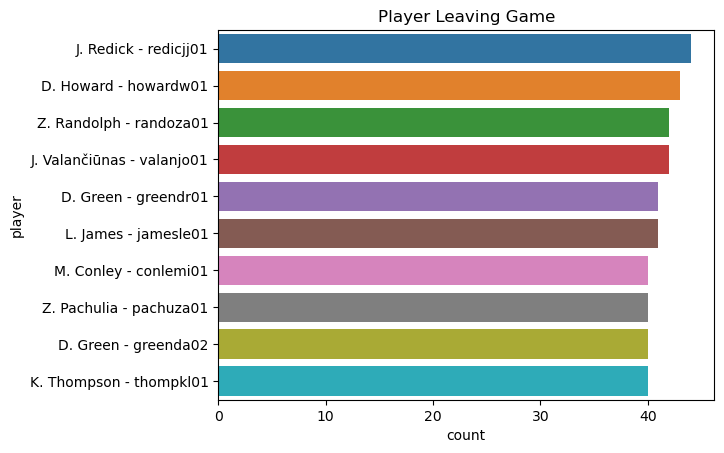

In [204]:
leave_game = dec_df[dec_df['class'] == 1][['LeaveGame1', 'LeaveGame2', 'LeaveGame3', 'LeaveGame4',
                     'LeaveGame5', 'LeaveGame6', 'LeaveGame7', 'LeaveGame8', 
                     'LeaveGame9', 'LeaveGame10']]

leave_game_df = pd.DataFrame(leave_game.stack().reset_index())
del leave_game_df['level_0']
del leave_game_df['level_1']
leave_game_df.columns = ['player']
leave_game_vc = pd.DataFrame(leave_game_df.value_counts())
leave_game_vc.columns = ['count']
sns.barplot(data=leave_game_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Player Leaving Game')
plt.show()

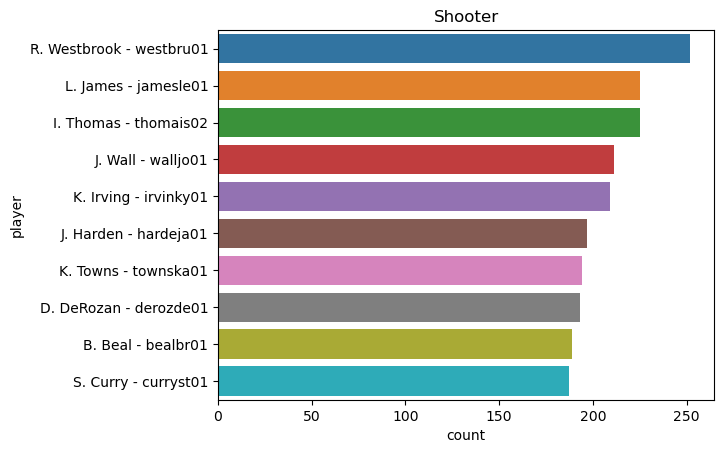

In [205]:
shooter = dec_df[dec_df['class'] == 1][['Shooter1', 'Shooter2', 'Shooter3', 'Shooter4', 
                     'Shooter5', 'Shooter6', 'Shooter7', 'Shooter8', 
                     'Shooter9', 'Shooter10']]

shooter_df = pd.DataFrame(shooter.stack().reset_index())
del shooter_df['level_0']
del shooter_df['level_1']
shooter_df.columns = ['player']
shooter_df = shooter_df[shooter_df.player != 'Team']
shooter_vc = pd.DataFrame(shooter_df.value_counts())
shooter_vc.columns = ['count']
sns.barplot(data=shooter_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Shooter')
plt.show()

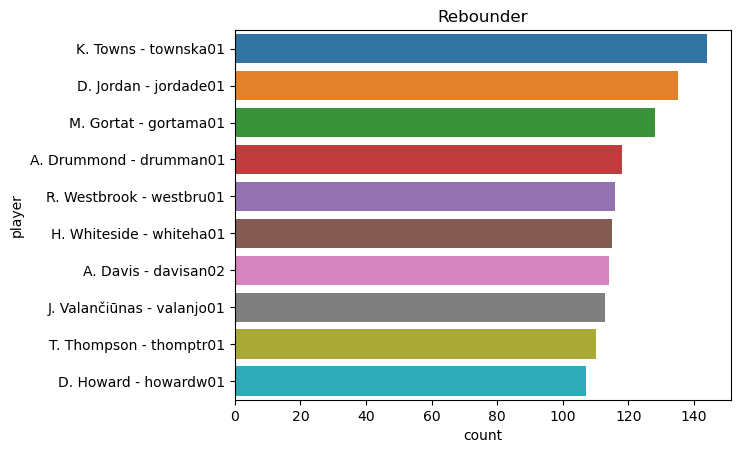

In [206]:
rebounder = dec_df[dec_df['class'] == 1][['Rebounder1', 'Rebounder2', 'Rebounder3', 
                   'Rebounder4', 'Rebounder5', 'Rebounder6', 
                   'Rebounder7', 'Rebounder8', 'Rebounder9', 'Rebounder10']]

rebounder_df = pd.DataFrame(rebounder.stack().reset_index())
del rebounder_df['level_0']
del rebounder_df['level_1']
rebounder_df.columns = ['player']
rebounder_df = rebounder_df[rebounder_df.player != 'Team']
rebounder_vc = pd.DataFrame(rebounder_df.value_counts())
rebounder_vc.columns = ['count']
sns.barplot(data=rebounder_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Rebounder')
plt.show()

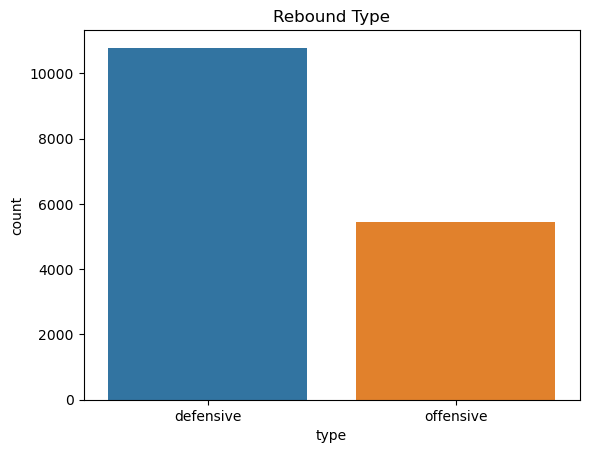

In [214]:
rebound_type = dec_df[dec_df['class'] == 1][['ReboundType1', 'ReboundType2', 'ReboundType3', 
                   'ReboundType4', 'ReboundType5', 'ReboundType6', 
                   'ReboundType7', 'ReboundType8', 'ReboundType9', 'ReboundType10']]

rebound_type_df = pd.DataFrame(rebound_type.stack().reset_index())
del rebound_type_df['level_0']
del rebound_type_df['level_1']
rebound_type_df.columns = ['type']
rebound_type_df = rebound_type_df[rebound_type_df.type != 'Team']
rebound_type_vc = pd.DataFrame(rebound_type_df.value_counts())
rebound_type_vc.columns = ['count']
sns.barplot(data=rebound_type_vc.reset_index().head(10), x = 'type', y = 'count')
plt.title('Rebound Type')
plt.show()

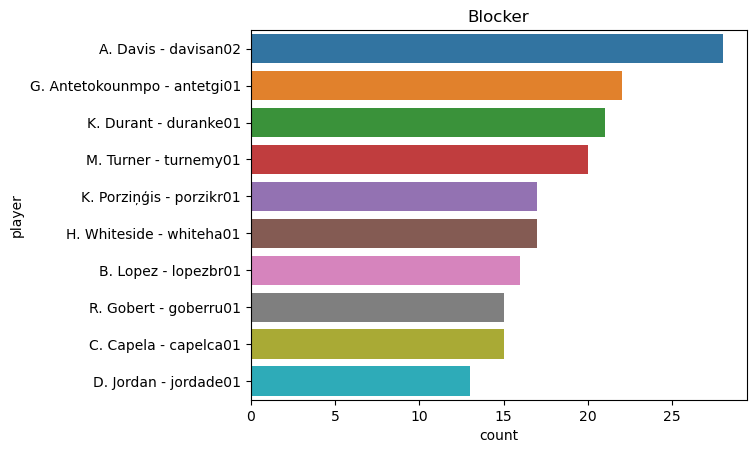

In [207]:
blocker = dec_df[dec_df['class'] == 1][['Blocker1', 'Blocker2', 'Blocker3', 'Blocker4', 
                     'Blocker5', 'Blocker6', 'Blocker7', 'Blocker8',
                     'Blocker9', 'Blocker10']]

blocker_df = pd.DataFrame(blocker.stack().reset_index())
del blocker_df['level_0']
del blocker_df['level_1']
blocker_df.columns = ['player']
blocker_vc = pd.DataFrame(blocker_df.value_counts())
blocker_vc.columns = ['count']
sns.barplot(data=blocker_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Blocker')
plt.show()

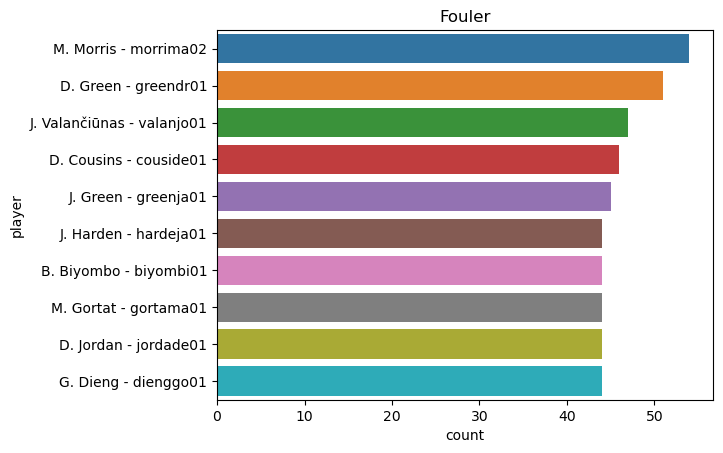

In [208]:
fouler = dec_df[dec_df['class'] == 1][['Fouler1', 'Fouler2', 'Fouler3', 'Fouler4', 
                     'Fouler5', 'Fouler6', 'Fouler7', 'Fouler8',
                     'Fouler9', 'Fouler10']]

fouler_df = pd.DataFrame(fouler.stack().reset_index())
del fouler_df['level_0']
del fouler_df['level_1']
fouler_df.columns = ['player']
fouler_vc = pd.DataFrame(fouler_df.value_counts())
fouler_vc.columns = ['count']
sns.barplot(data=fouler_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Fouler')
plt.show()

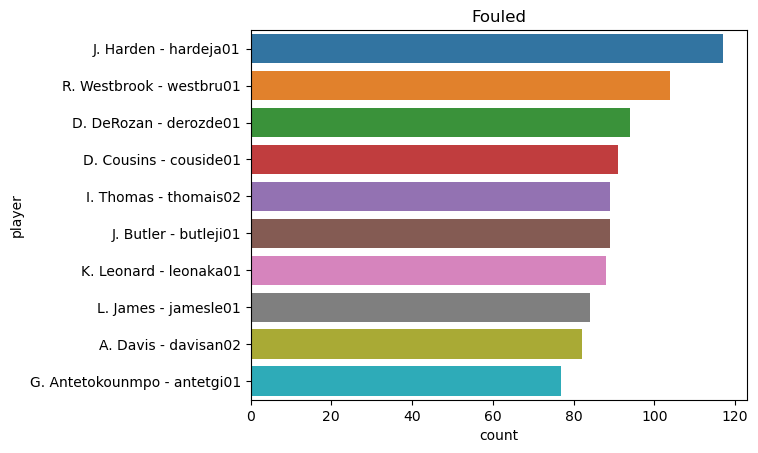

In [209]:
fouled = dec_df[dec_df['class'] == 1][['Fouled1', 'Fouled2', 'Fouled3', 'Fouled4', 
                     'Fouled5', 'Fouled6', 'Fouled7', 'Fouled8',
                     'Fouled9', 'Fouled10']]

fouled_df = pd.DataFrame(fouled.stack().reset_index())
del fouled_df['level_0']
del fouled_df['level_1']
fouled_df.columns = ['player']
fouled_vc = pd.DataFrame(fouled_df.value_counts())
fouled_vc.columns = ['count']
sns.barplot(data=fouled_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('Fouled')
plt.show()

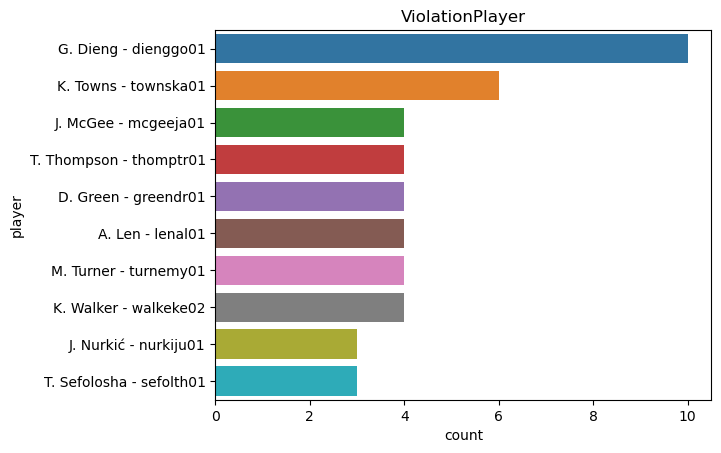

In [220]:
viol_player = dec_df[dec_df['class'] == 1][['ViolationPlayer1', 'ViolationPlayer2', 'ViolationPlayer3', 'ViolationPlayer4', 
                     'ViolationPlayer5', 'ViolationPlayer6', 'ViolationPlayer7', 'ViolationPlayer8',
                     'ViolationPlayer9', 'ViolationPlayer10']]

viol_player_df = pd.DataFrame(viol_player.stack().reset_index())
del viol_player_df['level_0']
del viol_player_df['level_1']
viol_player_df.columns = ['player']
viol_player_df = viol_player_df[viol_player_df.player != 'Team']
viol_player_vc = pd.DataFrame(viol_player_df.value_counts())
viol_player_vc.columns = ['count']
sns.barplot(data=viol_player_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('ViolationPlayer')
plt.show()

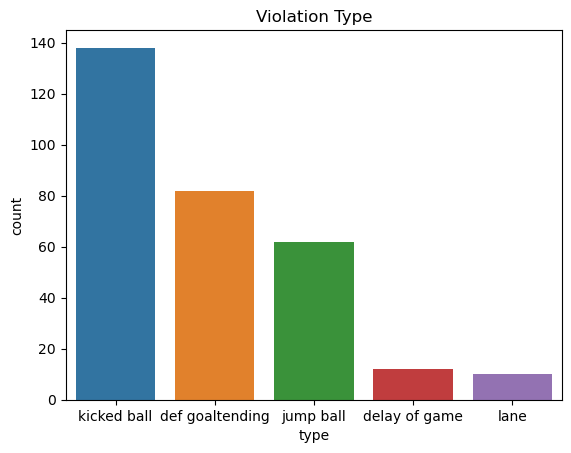

In [221]:
viol_type = dec_df[dec_df['class'] == 1][['ViolationType1', 'ViolationType2', 'ViolationType3', 
                   'ViolationType4', 'ViolationType5', 'ViolationType6', 
                   'ViolationType7', 'ViolationType8', 'ViolationType9', 'ViolationType10']]

viol_type_df = pd.DataFrame(viol_type.stack().reset_index())
del viol_type_df['level_0']
del viol_type_df['level_1']
viol_type_df.columns = ['type']
viol_type_df = viol_type_df[viol_type_df.type != 'Team']
viol_type_vc = pd.DataFrame(viol_type_df.value_counts())
viol_type_vc.columns = ['count']
sns.barplot(data=viol_type_vc.reset_index().head(10), x = 'type', y = 'count')
plt.title('Violation Type')
plt.show()

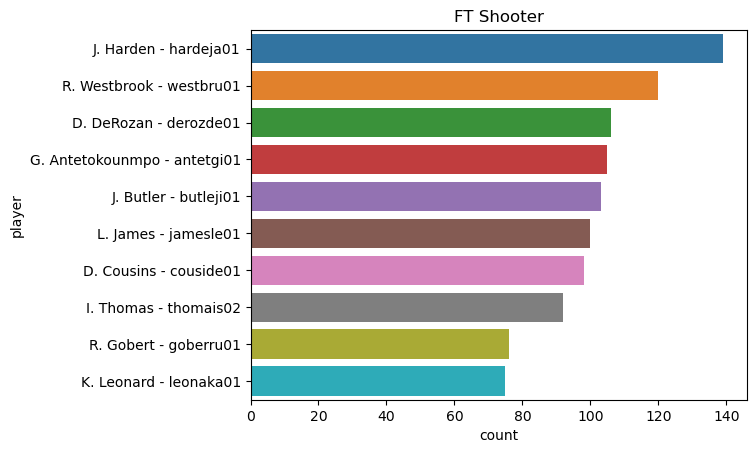

In [224]:
ft_shooter = dec_df[dec_df['class'] == 1][['FreeThrowShooter1', 'FreeThrowShooter2', 'FreeThrowShooter3', 'FreeThrowShooter4', 
                     'FreeThrowShooter5', 'FreeThrowShooter6', 'FreeThrowShooter7', 'FreeThrowShooter8', 
                     'FreeThrowShooter9', 'FreeThrowShooter10']]

ft_shooter_df = pd.DataFrame(ft_shooter.stack().reset_index())
del ft_shooter_df['level_0']
del ft_shooter_df['level_1']
ft_shooter_df.columns = ['player']
ft_shooter_df = ft_shooter_df[ft_shooter_df.player != 'Team']
ft_shooter_vc = pd.DataFrame(ft_shooter_df.value_counts())
ft_shooter_vc.columns = ['count']
sns.barplot(data=ft_shooter_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('FT Shooter')
plt.show()

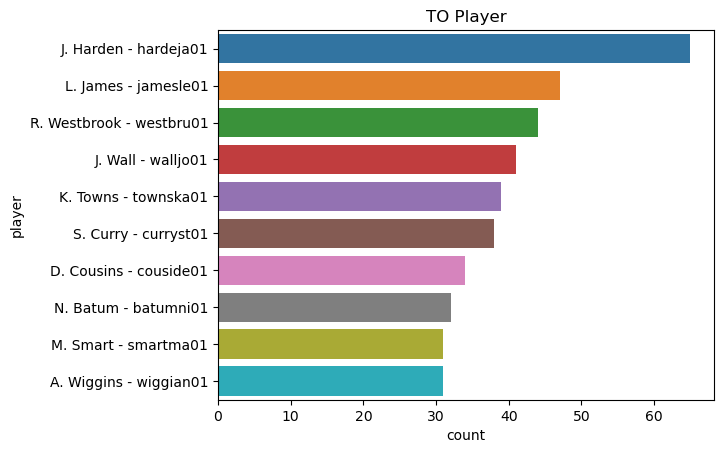

In [225]:
to_player = dec_df[dec_df['class'] == 1][['TurnoverPlayer1', 'TurnoverPlayer2', 'TurnoverPlayer3', 'TurnoverPlayer4', 
                     'TurnoverPlayer5', 'TurnoverPlayer6', 'TurnoverPlayer7', 'TurnoverPlayer8', 
                     'TurnoverPlayer9', 'TurnoverPlayer10']]

to_player_df = pd.DataFrame(to_player.stack().reset_index())
del to_player_df['level_0']
del to_player_df['level_1']
to_player_df.columns = ['player']
to_player_df = to_player_df[to_player_df.player != 'Team']
to_player_vc = pd.DataFrame(to_player_df.value_counts())
to_player_vc.columns = ['count']
sns.barplot(data=to_player_vc.reset_index().head(10), x = 'count', y = 'player')
plt.title('TO Player')
plt.show()

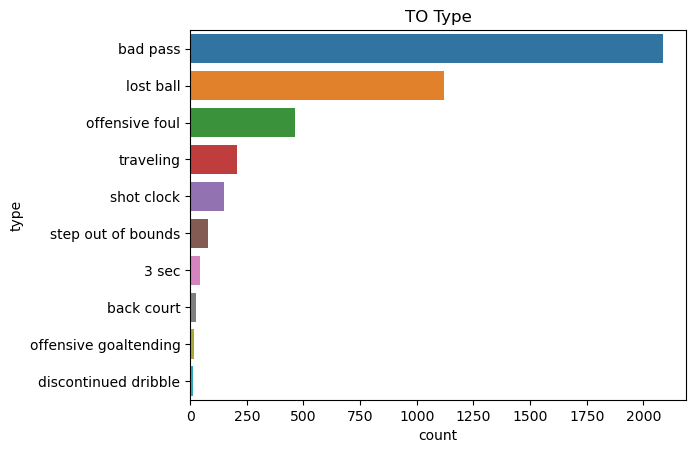

In [228]:
to_type = dec_df[dec_df['class'] == 1][['TurnoverType1', 'TurnoverType2', 'TurnoverType3', 
                   'TurnoverType4', 'TurnoverType5', 'TurnoverType6', 
                   'TurnoverType7', 'TurnoverType8', 'TurnoverType9', 'TurnoverType10']]

to_type_df = pd.DataFrame(to_type.stack().reset_index())
del to_type_df['level_0']
del to_type_df['level_1']
to_type_df.columns = ['type']
to_type_df = to_type_df[to_type_df.type != 'Team']
to_type_vc = pd.DataFrame(to_type_df.value_counts())
to_type_vc.columns = ['count']
sns.barplot(data=to_type_vc.reset_index().head(10), x = 'count', y = 'type')
plt.title('TO Type')
plt.show()

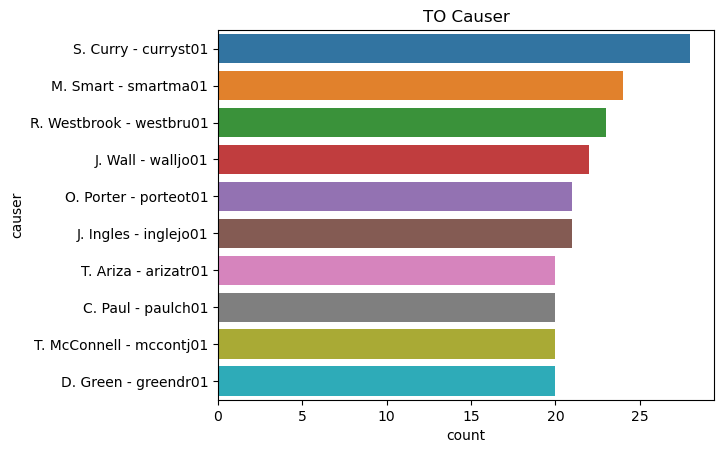

In [235]:
to_causer = dec_df[dec_df['class'] == 1][['TurnoverCauser1', 'TurnoverCauser2', 'TurnoverCauser3', 
                   'TurnoverCauser4', 'TurnoverCauser5', 'TurnoverCauser6', 
                   'TurnoverCauser7', 'TurnoverCauser8', 'TurnoverCauser9', 'TurnoverCauser10']]

to_causer_df = pd.DataFrame(to_causer.stack().reset_index())
del to_causer_df['level_0']
del to_causer_df['level_1']
to_causer_df.columns = ['causer']
to_causer_df = to_causer_df[to_causer_df.causer != 'Team']
to_causer_vc = pd.DataFrame(to_causer_df.value_counts())
to_causer_vc.columns = ['count']
sns.barplot(data=to_causer_vc.reset_index().head(10), x = 'count', y = 'causer')
plt.title('TO Causer')
plt.show()